# Demystifying Gradients in CNN

Gradients are those mysterious creatures found in every nook and corner of intelligent designs. It forms bedrock for all the intelligent systems around. In this blog, we will try and dig deeper into world of gradients ,starting from tiny world of derivatives straight upto how training of CNN is strongly tied with this basic understanding.

## Derivatives
Derivative is nothing but gradient with just one variable. The simplest example is to calculate derivative of $f(x) = 2*x^2 $ with respect to x, and evaluate it for $x=3$. The value of derivative is $$ \lbrack 4*x \rbrack _{(x=3)}=12 $$

In [7]:
import tensorflow as tf;
x= tf.placeholder(tf.float32);
fx =2*x*x;
grads =tf.gradients(fx,x)
with tf.Session() as sess:
    print (sess.run(grads,feed_dict={x:3.0}))

[12.0]


As we can see, tensorflow's answer matches our high school caluculation of derivates. What if we want to calcuate gradient for multivariate function such as $f(x,y) = 2x^2+3y^2$ w.r.t (x,y)? In this case, it calculates partial derivative of function with respect to each variable and substitute the value.
$$ \underbrace{\nabla f(x,y)}_{\text{w.r.t }(x,y)} = \underbrace{\begin{bmatrix} 4x \\ 6y \end{bmatrix} }_{(x=3,y=5)}  = \begin{bmatrix} 12 \\ 30 \end{bmatrix}  $$


In [6]:
import tensorflow as tf;
x= tf.placeholder(tf.float32);
y= tf.placeholder(tf.float32);
fxy =2*x*x+3*y*y;
grads =tf.gradients(fxy,[x,y])
with tf.Session() as sess:
    print (sess.run(grads,feed_dict={x:3.0,y:5.0}))

[12.0, 30.0]


Also note, that larger the weightage of that term in loss function, the larger will the gradient w.r.t that variable.Let us now see, how gradients work when we have a convolutional layer in CNN.

### Understanding Gradients for Convolutional Layers

In [34]:
# Manual Convolution
#(Assume filter is already flipped)
import tensorflow as tf;
import numpy as np;
def conv(x,h):
    out =[]
    for i in range(6-3+1):
        out.append(tf.tensordot(x[i:i+3],h,axes=1))
    return tf.convert_to_tensor(out)
x = tf.placeholder(tf.float32,shape=(6))
h = tf.Variable(np.array([1,2,3]),dtype=tf.float32)
out = tf.reduce_sum(conv(x,h))
grads = tf.gradients(out,h)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer());
    print (sess.run(out,feed_dict={x : np.array([1,2,3,1,1,1])}))
    print (sess.run(grads,feed_dict={x : np.array([1,2,3,1,1,1])}))

39.0
[array([ 7.,  7.,  6.], dtype=float32)]


### Q ) Can you calculate this output? 

It is pretty simple. Let us say, I want to find gradient for $0^{th}$ multiplier (a.k.a hidden variable). This will be nothing but partial derivative of the output(or reduce sum form of output, if it is not single value) with respect to $h[0]$. $$\cfrac{\partial (x*h)}{\partial h[0]}$$
Looks scary, huh ?
But explaination can be simplified, if we can write convolution as a matrix operation. (Note : It won't match with textbook as textbook will have flipped version of it + we have slided the filter, First times, please ignore this note )
$$\begin{bmatrix}y[0]\\y[1]\\y[2]\\y[3] \end{bmatrix} = \begin{bmatrix}\textbf{x[0]} & x[1] & x[2] \\ \textbf{x[1]} & x[2] & x[3]  \\ \textbf{x[2]} & x[3] & x[4]  \\ \textbf{x[3]} & x[4] & x[5] \end{bmatrix}\begin{bmatrix}\textbf{h[0]}\\h[1]\\h[2] \end{bmatrix}$$
On one level, when we say gradient with respect to h[0], what grad for h[0] is saying is that, hey remove all terms that are not multiplied with me, and then sum all that is attached to me. 

As I have highlighted, the embolded $[x[0],x[1],x[2],x[3]]$ are the ones, which are multiplied with $h[0]$ in one or the other way. Sum them up, and you get the output of gradient value corrosponding to $h[0]$ ! Simple :) 

### Gradients for MaxPooling 

In [49]:
# Manual Convolution
#(Assume filter is already flipped)
import tensorflow as tf;
import numpy as np;
def pool(x):
    out =[]
    for i in range(6-3+1):
        out.append(tf.reduce_max(x[i:i+3]))
    return tf.convert_to_tensor(out)
x = tf.placeholder(tf.float32,shape=(6))
out = tf.reduce_sum(pool(x))
grads = tf.gradients(out,x)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer());
    print (sess.run(out,feed_dict={x : np.array([1,2,3,1,1,1])}))
    print (sess.run(grads,feed_dict={x : np.array([1,2,3,1,1,1])}))

10.0
[array([ 0.        ,  0.        ,  3.        ,  0.33333334,  0.33333334,
        0.33333334], dtype=float32)]


This one is tricky one. Out of all 4 values, it goes and sits out for highest value. Therefore, it leads to loss of information too.

## Gradient of Sigmoid output

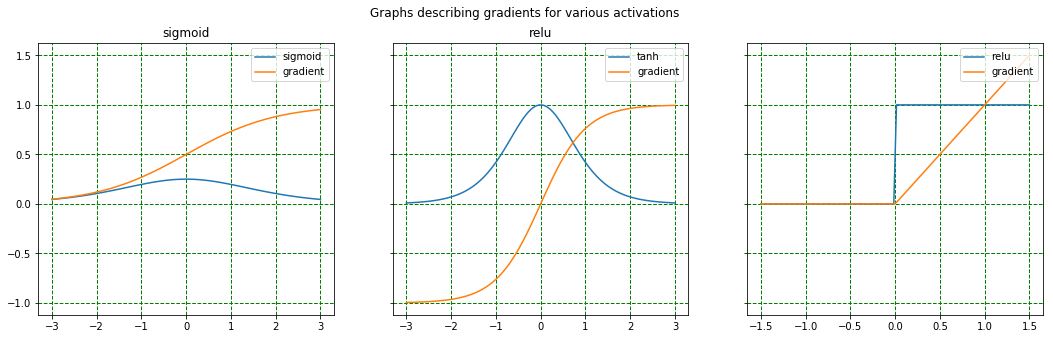

In [65]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
x= tf.placeholder(tf.float32);
fsigma = tf.nn.sigmoid(x);
frelu = tf.nn.relu(x);
ftanh = tf.nn.tanh(x)
gradsigma =tf.gradients(fsigma,x)
gradrelu = tf.gradients(frelu,x)
gradtanh = tf.gradients(ftanh,x)
f,axarr = plt.subplots(1,3,figsize=(18,5),sharey=True)
with tf.Session() as sess:
    xval = np.linspace(-3,3,100)
    # Gradient Calculation for Sigmoid;
    gradsigmaval,sigmaval = (sess.run([gradsigma,fsigma],feed_dict={x:xval}))
    
    axarr[0].grid(color='g', linestyle='--', linewidth=1)
    axarr[0].plot(xval,np.squeeze(gradsigmaval),label='sigmoid');
    axarr[0].plot(xval,np.squeeze(sigmaval),label="gradient");
    axarr[0].set_title("sigmoid");
    axarr[0].legend(loc="upper right")

    # Gradient Calculation for tanh;
    gradtanhval,tanhval = (sess.run([gradtanh,ftanh],feed_dict={x:xval}))
    
    axarr[1].grid(color='g', linestyle='--', linewidth=1)
    axarr[1].plot(xval,np.squeeze(gradtanhval),label="tanh");
    axarr[1].plot(xval,np.squeeze(tanhval),label="gradient");
    axarr[1].set_title("tanh");
    axarr[1].legend(loc="upper right")

    # Gradient Calculation for relu;
    xval = np.linspace(-1.5,1.5,100)
    gradreluval,reluval = (sess.run([gradrelu,frelu],feed_dict={x:xval}))    
    axarr[2].grid(color='g', linestyle='--', linewidth=1)
    axarr[2].plot(xval,np.squeeze(gradreluval),label="relu");
    axarr[2].plot(xval,np.squeeze(reluval),label="gradient");
    axarr[1].set_title("relu");
    axarr[2].legend(loc="upper right")
    f.suptitle("Graphs describing gradients for various activations")
    plt.show()

## A Step by step Backpropogation Example
*Inspired and followed up from Matt Muzer Explaination*
 https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
